In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, Binarizer, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.metrics import average_precision_score, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA, SparsePCA 
from joblib import Parallel, delayed
import itertools
%matplotlib inline

    1. pca
    2. removing high correlation columns
    3. feature selection
    4. onehot encoding drop first column. 
    5. remove everything that I'm not positive is time independent. 

binning problems
different paradigms
different models, something simple.

Things to fix:
one-hot encoding drop first columns
also drop in encoding dates.

Things to test today.
X -> scaled -> pca 

Sample sizes. 

In [67]:
def my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=StandardScaler()):
    ''' Transform features using a column transformer. 
    
    A DataFrame which takes mixed "Missing" and datetime values, separates out the "Missing"
    and then performs two operations. First, the 'Missing' column is one-hot encoded, second,
    the datetime variables are binned and encoded using KBinsDiscretizer, using a uniform bin
    width strategy. 

    Parameters
    ----------

    X : DataFrame (n_samples, n_features)
         
        Dataframe which contains training data. 

    num_features : list, Pandas index
    
        List of Pandas Index of the name of columns that contain numerical features.
         

    cat_features : list, Pandas index
    
        List of Pandas Index of the name of columns that contain categorical features.
         
    date_features : list, Pandas index
    
        List of Pandas Index of the name of columns that contain categorical features.
         
        Dataframe which contains datetime features and value "Missing" which indicates missing values.

    num_transformer : scikit-learn Transformer
         
        scikit-learn scaler such as QuantileTransformer(), MinMaxScaler(), etc.

    Returns
    -------

    col_transformer : ColumnTransformer instance
    
         Transformer that can be used to rescale and encode data. 
            
    '''
    
    uniq_categories = [list(np.sort(X[col].unique()))for col in cat_features]

    cat_transformer = OneHotEncoder(categories=uniq_categories, drop='first')
    
    if date_features is None:
        col_transformer = ColumnTransformer(transformers=[('num', num_transformer, num_features), 
                                                          ('cat', cat_transformer, cat_features)])
    else:
        col_transformer = ColumnTransformer(transformers=[('num', num_transformer, num_features), 
                                                          ('cat', cat_transformer, cat_features),
                                                         ('my_kbd', 'passthrough', date_features)])

    return col_transformer


In [68]:
# Function that combines different classification metrics to avoid repeated large blocks of code.
# Produces the confusion matrix, classification report (precision, recall, f1-score,..)
# ROC-AUC and ROC curve
# Precision-recall curve

def my_score(clf, X_test, y_test):
    ''' Predict using trained scikit-learn estimator and compute the explained variance score.  

    Parameters
    ----------
    X_test : ndarray or DataFrame (n_samples, n_features)
             Feature data to test. n_features represents the number of features
             present in the data used to train the estimator clf

    y_test : ndarray (n_samples, )
             Target data to test. 


    clf : scikit-learn estimator which has been fit to data with same number of columns as X_test

    '''
    y_predict_proba= clf.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, y_predict_proba)


def classifier_analysis(clf, xt, yt):
    ''' Predict and measure quality of model with a variety of metrics.   

    Parameters
    ----------

    xt : ndarray or DataFrame (n_samples, n_features)
             Feature data to test. n_features represents the number of features
             present in the data used to train the estimator clf

    yt : ndarray (n_samples, )
             Target data to test. 


    clf : scikit-learn estimator which has been fit to data with same number of columns as X_test

    '''
    y_predict = clf.predict(xt)
    y_predict_proba= clf.predict_proba(xt)[:,1]

    cm = confusion_matrix(yt, y_predict, labels=[0,1])
    print('tn, fp, fn, tp', cm.ravel())
    _ = ConfusionMatrixDisplay(cm / yt.size, [0,1]).plot()
    
    print(classification_report(yt, y_predict))

    roc_auc = roc_auc_score(yt, y_predict_proba)
    fpr, tpr, thresholds = roc_curve(yt, y_predict_proba)

    plt.figure()
    plt.plot(fpr, tpr, label=(clf.__class__.__name__ + '(area = %0.2f)' % roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    average_precision = average_precision_score(yt, y_predict_proba)
    precision, recall, thresholds = precision_recall_curve(yt, y_predict_proba)
    disp = plot_precision_recall_curve(clf, xt, yt)
    disp.ax_.set_ylim([0.0, 1.0])
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    plt.show()
    
    return roc_auc


# Convert date-like + 'Missing' valued features to one-hot encoded columns; uses KBins on the years of the date-like, which 
# bins then one-hot encodes, while also one-hot encoding 'Missing' separately. 
def encode_dates_and_missing(df):
    for i, seriesname in enumerate(df.columns):
        series = df[seriesname]
        series_missing = pd.get_dummies(series[series=='Missing'])
        series_notmissing = series[series!='Missing']
        notmiss_index =series_notmissing.index
        
        kbd = KBinsDiscretizer(n_bins=3, strategy='uniform')
        series_dt = pd.to_datetime(series_notmissing).dt.year
        encoded_series = kbd.fit_transform(series_dt.values.reshape(-1,1))
        encoded_series = pd.DataFrame(kbd.fit_transform(series_dt.values.reshape(-1,1)).toarray(),index=notmiss_index).astype(int)
        encoded_series = encoded_series.join(series_missing, how='outer').fillna(value=0)
        encoded_series.columns = [seriesname+'_'+str(col) for col in encoded_series.columns]
        encoded_series = encoded_series.iloc[:, 1:]
        if i == 0: 
            encoded_df = encoded_series
        else:
            encoded_df = pd.concat((encoded_df,encoded_series),axis=1)
            
    return encoded_df



In [69]:
def scale_features(col_transformer_, X_train, X_test):
    _ = col_transformer_.fit(X_train)
    X_train = col_transformer_.transform(X_train)
    X_test = col_transformer_.transform(X_test)
    return X_train, X_test


def my_cross_validate(estimator, col_transformer_, X_traintest, y_traintest, train_test_iterable, param_grid, n_jobs=-2):
    mean_scores = []
    # cv_params needs to make sense for the estimator given
    param_grid_list = param_grid_iterable(param_grid)
    for params_ in param_grid_list:
        with Parallel(n_jobs=-2) as parallel:
            fitted_models_and_test_splits = parallel(delayed(fit_model_)(estimator(**params_), col_transformer_,
                                                          X_traintest, y_traintest, train, test)
                                  for (train, test) in train_test_iterable)
            # Get averages (explained variance) score for this model
            scores = parallel(delayed(my_score)(model_, xt, yt) for (model_, xt, yt) in fitted_models_and_test_splits) 
            mean_scores += [np.mean(list(scores))]
            
    
    best_params_ = param_grid_list[np.argmax(np.array(mean_scores))]
    return estimator(**best_params_) 


def fit_model_(estimator, col_transformer_, X_traintest, y_traintest, train, test):
    X_train, X_test = X_traintest.loc[train,:], X_traintest.loc[test,:]
    y_train, y_test = y_traintest.loc[train].values.ravel(), y_traintest.loc[test].values.ravel()
    
    X_train, X_test  = scale_features(col_transformer_, X_train, X_test)
    
    _ = estimator.fit(X_train, y_train)    
    return (estimator, X_test, y_test)

def param_grid_iterable(params):
    keys = sorted(params)
    combinations = list(itertools.product(*(params[key] if type(params[key]) in [list, dict, np.ndarray] else [params[key]]
                                            for key in keys)))
    cvsorted = [dict(zip(len(c)*keys, c)) for c in combinations]
    return cvsorted

### Random Forest and Logistic Regression modeling of loan status.

In [70]:
loan_data = pd.read_csv('classification_loan_data_ind.csv', index_col=False)

Need to take into consideration the time dependence element of this problem. Because we want to predict whether or not
to issue a loan, need to take into consideration the time series nature of the issuance date. The main consideration is during the cross-validation process later but reorder the data now as it will later be transformed by one-hot encoding. Specifically, it will be stored in a sparse matrix which is harder to manipulate.

In [6]:
# This step will be deprecated after newest data cleaning run. 
issued_datetime = pd.to_datetime(loan_data.issue_d)

loan_data = loan_data.loc[issued_datetime.sort_values().index,:]

Have the cross validation folds, now need to create procedure which correctly preprocesses them before testing. Training component of folds are cumulative over time; always want to use as much information as possible.

There are too many values for the dates of the earliest credit known credit lines and zip codes; too many at least for one-hot encoding to be practical. Therefore, group zip_code by the first two digits as this retains the geographical information and group the earliest credit_line by using KBinsDiscretizer on the year; it needs a numerical value so the entire date cannot be used without modification. The reason for KBinsDiscretizer is that the distribution is not uniform over time, and it presents an unbiased selection/grouping method.

In [7]:
encoded_dates = encode_dates_and_missing(loan_data.loc[:, 'earliest_cr_line'].to_frame(name='earliest_cr_line'))

In [8]:
date_features = encoded_dates.columns

In [9]:
loan_data = pd.concat((loan_data, encoded_dates),axis=1)

In [10]:
y = loan_data.loan_status.astype(int)
# Dump everything with high correlations
X = loan_data.drop(columns=['loan_status','zip_code', 'earliest_cr_line','funded_amnt_inv','funded_amnt','installment'])

Create a "hold-out" set of data that will used for final predictions and analysis after all cross-validation and
model learning has been accomplished. The loan issuance dates are aggregated by month, but from the metadata we know that the data is reported *quarterly*. Using this as motivation, the hold-out data will be the most recent quarter. Because the number of loans has grown over time, this one quarter represents nearly $1 / 7$ of all loan data of loans that have either been fully paid or charged off.

In [11]:
# Data goes from second quarter of 2007 to fourth quarter of 2015; the number of samples are skewed toawrds later dates;
# The data is reported quarterly; this should be represented in the cross validation/model selection process.
pind = pd.PeriodIndex(issued_datetime, freq='Q-DEC')

KBins needs numerical variables; use year.quarter (number.decimal). This transformation is not applied to the training data; it's just used

In [12]:
# Add the year to the decimal representing the quarter; Q1 = 0.0 , Q2 = 0.25, Q3 = 0.50, Q4 = 0.75
numerical_quarters = pind.year + (pind.quarter - 1)/4

In [13]:
nb=6
kbd = KBinsDiscretizer(n_bins=nb)
bin_masks = kbd.fit_transform(numerical_quarters.values.reshape(-1, 1)).toarray()

Size of the cross-validation folds

In [14]:
np.sum(bin_masks, axis=0)

array([ 93153.,  90943., 115805., 147183.,  64222., 162063.])

Scikit-learn wants iterable containing (train_indices, test_indices)

In [15]:
train_indices = [loan_data.index[np.array(np.sum(bin_masks[:,:i+1],axis=1), dtype=bool)]  for i in range(nb-2)]
test_indices = [loan_data.index[np.array(bin_masks[:,i+1], dtype=bool)]  for i in range(nb-2)]
train_test_iterable = list(zip(train_indices,test_indices))
traintest_indices = loan_data.index[np.array(np.sum(bin_masks[:,:-1],axis=1), dtype=bool)] 
holdout_indices = loan_data.index[np.array(bin_masks[:, -1], dtype=bool)] 

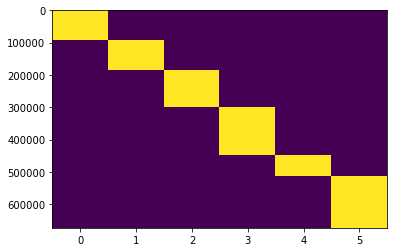

In [16]:
plt.imshow(bin_masks,aspect='auto')

In [52]:
num_features = X.select_dtypes(exclude=['object','category']).columns
cat_features = X.select_dtypes(include=['object','category']).columns
date_features = encoded_dates.columns

In [71]:
train0, test0 = train_test_iterable[3]
X_train, X_test = X.loc[train0, :],X.loc[test0, :]
y_train, y_test = y.loc[train0], y.loc[test0]

col_transformer = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=StandardScaler())

_ = col_transformer.fit(X_train)
X_train = col_transformer.transform(X_train)
X_test = col_transformer.transform(X_test)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [72]:
print('Shape of the training set {} and testing set {} after transformation'.format(X_train.shape, X_test.shape))

Shape of the training set (447084, 234) and testing set (64222, 234) after transformation


In [73]:
from sklearn.ensemble import RandomTreesEmbedding, ExtraTreesClassifier
hasher = RandomTreesEmbedding(n_estimators=20, random_state=0, max_depth=3)
X_train_transform = hasher.fit_transform(X_train)
X_test_transform = hasher.transform(X_test)

pca = PCA(n_components=10)
_ = pca.fit(X_train.toarray())
X_train_pca = pca.transform(X_train.toarray())
X_test_pca = pca.transform(X_test.toarray())

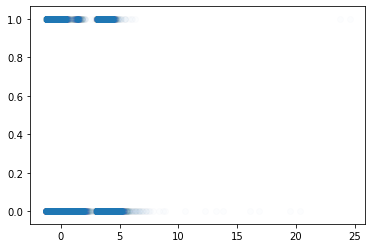

In [74]:
plt.scatter(X_train_pca[:,0], y_train, alpha=0.01)
_ = plt.show()

In [ ]:
random_forest_pca = RandomForestClassifier(n_estimators=10, class_weight='balanced')
_ = random_forest_pca.fit(X_train_pca, y_train)
random_forest_pca_roc_auc = classifier_analysis(random_forest_pca, X_train_pca, y_train)
random_forest_pca_roc_auc = classifier_analysis(random_forest_pca, X_test_pca, y_test)

tn, fp, fn, tp [78839     0 14306     8]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     78839
           1       1.00      0.00      0.00     14314

    accuracy                           0.85     93153
   macro avg       0.92      0.50      0.46     93153
weighted avg       0.87      0.85      0.78     93153



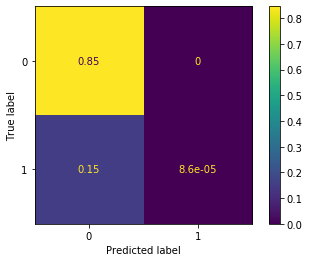

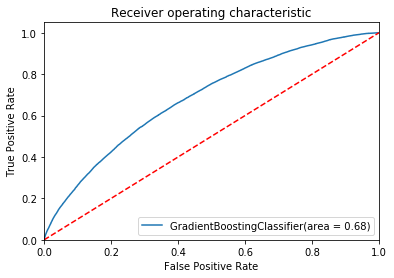

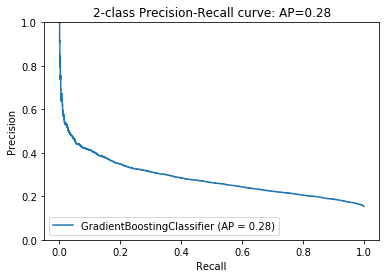

tn, fp, fn, tp [76647    54 14220    22]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     76701
           1       0.29      0.00      0.00     14242

    accuracy                           0.84     90943
   macro avg       0.57      0.50      0.46     90943
weighted avg       0.76      0.84      0.77     90943



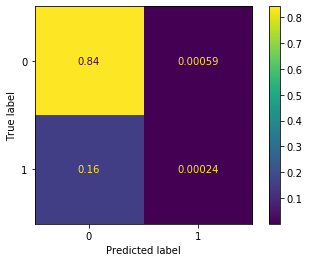

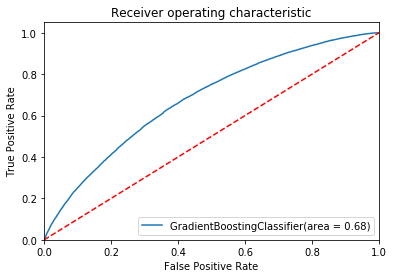

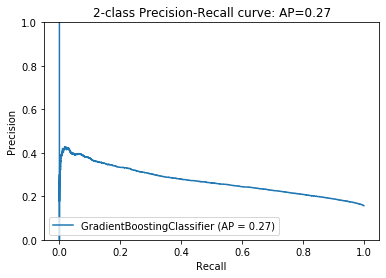

In [24]:
gradient_boosting_pca = GradientBoostingClassifier()
_ = gradient_boosting_pca.fit(X_train_pca, y_train)
gradient_boosting_pca_roc_auc_train = classifier_analysis(gradient_boosting_pca, X_train_pca, y_train)
gradient_boosting_pca_roc_auc_test = classifier_analysis(gradient_boosting_pca, X_test_pca, y_test)

tn, fp, fn, tp [78838     1 14312     2]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     78839
           1       0.67      0.00      0.00     14314

    accuracy                           0.85     93153
   macro avg       0.76      0.50      0.46     93153
weighted avg       0.82      0.85      0.78     93153



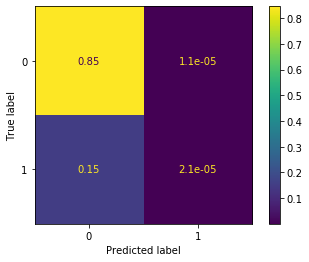

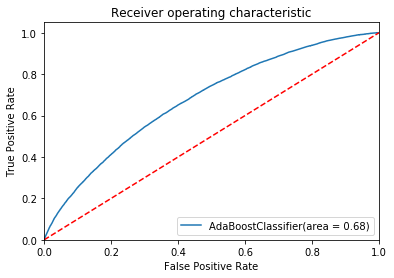

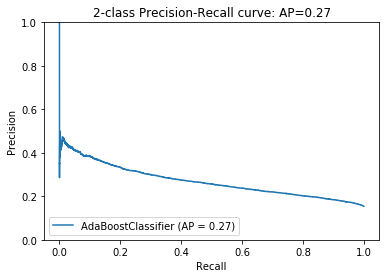

tn, fp, fn, tp [76660    41 14226    16]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     76701
           1       0.28      0.00      0.00     14242

    accuracy                           0.84     90943
   macro avg       0.56      0.50      0.46     90943
weighted avg       0.76      0.84      0.77     90943



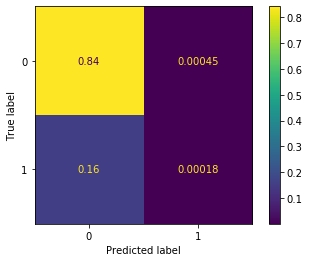

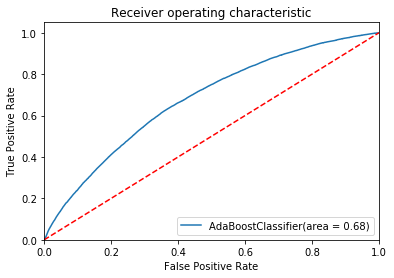

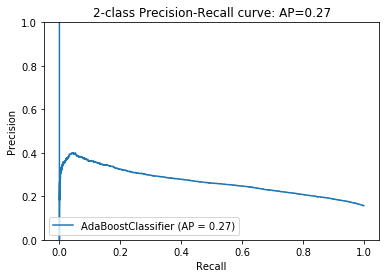

In [25]:
ada_boosting_pca = AdaBoostClassifier(learning_rate=0.1,n_estimators=1000,random_state=0)
_ = ada_boosting_pca.fit(X_train_pca, y_train)
ada_boosting_pca_roc_auc_train = classifier_analysis(ada_boosting_pca, X_train_pca, y_train)
ada_boosting_pca_roc_auc_test = classifier_analysis(ada_boosting_pca, X_test_pca, y_test)

tn, fp, fn, tp [49363 29476  5502  8812]
              precision    recall  f1-score   support

           0       0.90      0.63      0.74     78839
           1       0.23      0.62      0.34     14314

    accuracy                           0.62     93153
   macro avg       0.56      0.62      0.54     93153
weighted avg       0.80      0.62      0.68     93153



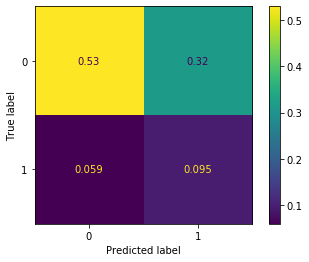

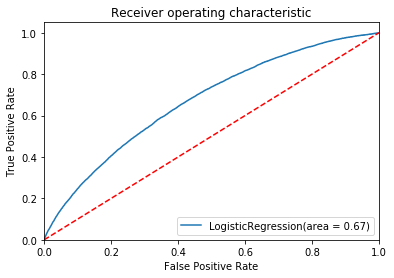

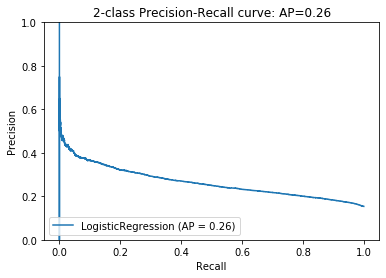

tn, fp, fn, tp [38681 38020  3649 10593]
              precision    recall  f1-score   support

           0       0.91      0.50      0.65     76701
           1       0.22      0.74      0.34     14242

    accuracy                           0.54     90943
   macro avg       0.57      0.62      0.49     90943
weighted avg       0.80      0.54      0.60     90943



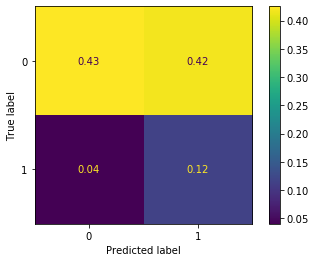

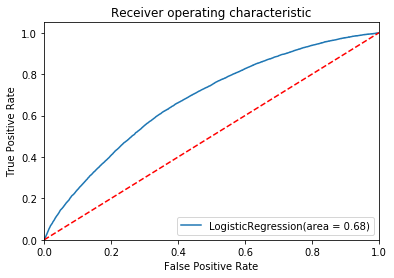

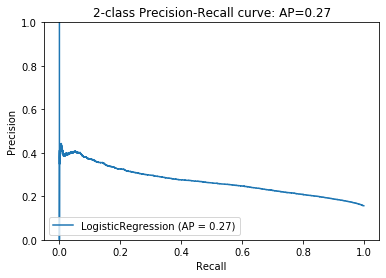

In [26]:
logistic_regression_pca = LogisticRegression(max_iter=1000, class_weight='balanced')
_ = logistic_regression_pca.fit(X_train_pca, y_train)
logreg_pca_roc_auc_train = classifier_analysis(logistic_regression_pca, X_train_pca, y_train)
logreg_pca_roc_auc_test = classifier_analysis(logistic_regression_pca, X_test_pca, y_test)

In [ ]:
random_forest0 = RandomForestClassifier(n_estimators=20, class_weight='balanced')
_ = random_forest0.fit(X_train, y_train)
random_forest0_roc_auc = classifier_analysis(random_forest0, X_train, y_train)
random_forest0_roc_auc = classifier_analysis(random_forest0, X_test, y_test)

tn, fp, fn, tp [49343 29496  5020  9294]
              precision    recall  f1-score   support

           0       0.91      0.63      0.74     78839
           1       0.24      0.65      0.35     14314

    accuracy                           0.63     93153
   macro avg       0.57      0.64      0.55     93153
weighted avg       0.81      0.63      0.68     93153



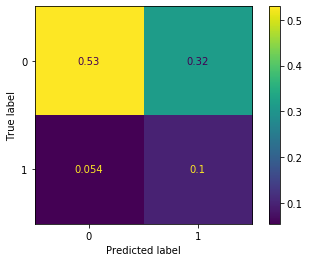

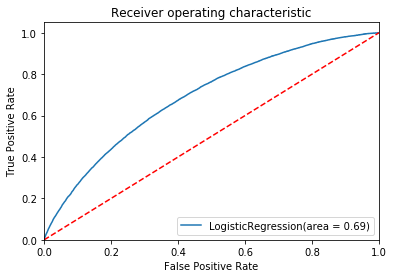

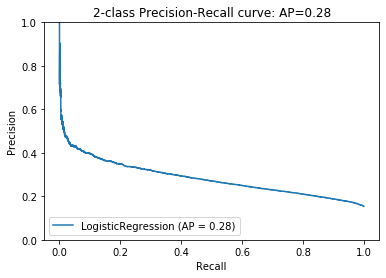

tn, fp, fn, tp [36980 39721  3290 10952]
              precision    recall  f1-score   support

           0       0.92      0.48      0.63     76701
           1       0.22      0.77      0.34     14242

    accuracy                           0.53     90943
   macro avg       0.57      0.63      0.48     90943
weighted avg       0.81      0.53      0.59     90943



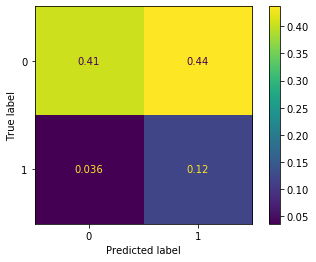

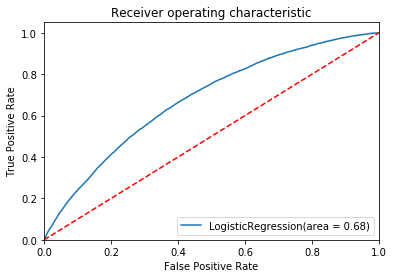

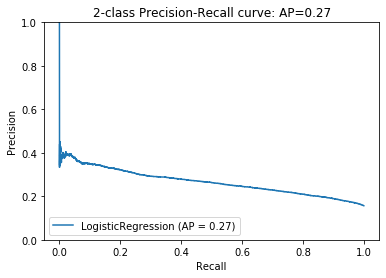

In [28]:
logistic_regression0 = LogisticRegression(max_iter=1000, tol=1e-09, class_weight='balanced')
_ = logistic_regression0.fit(X_train, y_train)
logreg0_roc_auc_train = classifier_analysis(logistic_regression0, X_train, y_train)
logreg0_roc_auc_test = classifier_analysis(logistic_regression0, X_test, y_test)

tn, fp, fn, tp [78839     0 14314     0]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     78839
           1       0.00      0.00      0.00     14314

    accuracy                           0.85     93153
   macro avg       0.42      0.50      0.46     93153
weighted avg       0.72      0.85      0.78     93153



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


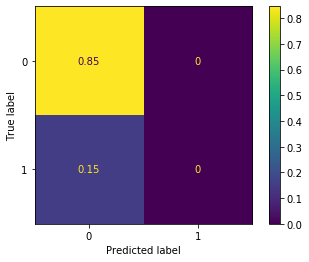

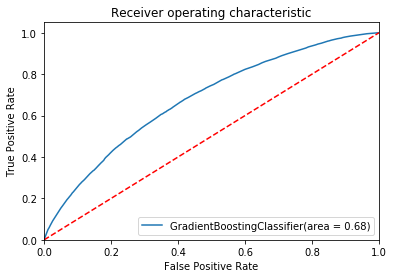

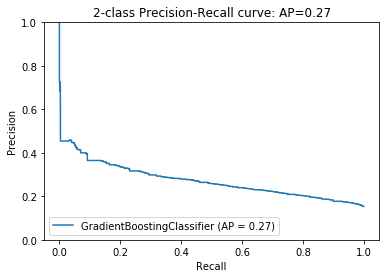

tn, fp, fn, tp [76701     0 14242     0]
              precision    recall  f1-score   support

           0       0.84      1.00      0.92     76701
           1       0.00      0.00      0.00     14242

    accuracy                           0.84     90943
   macro avg       0.42      0.50      0.46     90943
weighted avg       0.71      0.84      0.77     90943



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


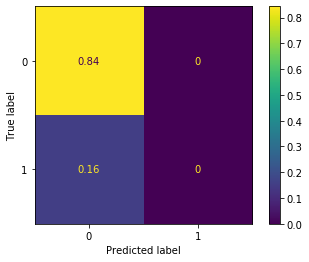

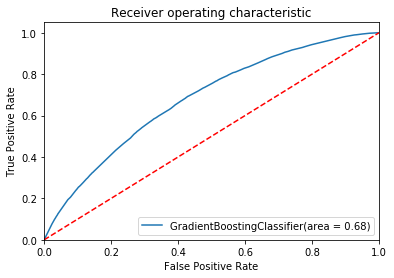

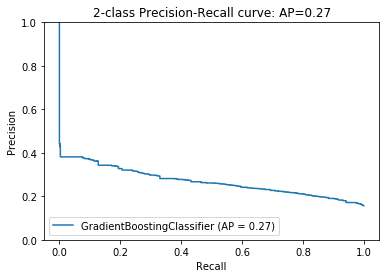

In [29]:
gradient_boosting0 = GradientBoostingClassifier(learning_rate=0.001, n_estimators=1000, random_state=0)
_ = gradient_boosting0.fit(X_train, y_train)
gradient_boosting0_roc_auc_train = classifier_analysis(gradient_boosting0, X_train, y_train)
gradient_boosting0_roc_auc_test = classifier_analysis(gradient_boosting0, X_test, y_test)

In [31]:
random_forest0 = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
_ = random_forest0.fit(X_train, y_train)
random_forest0_roc_auc = classifier_analysis(random_forest0, X_train, y_train)
random_forest0_roc_auc = classifier_analysis(random_forest0, X_test, y_test)

KeyboardInterrupt: 

In [30]:
ada_boosting_0 = AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=0)
_ = ada_boosting_0.fit(X_train, y_train)
ada_boosting_roc_auc_train_0 = classifier_analysis(ada_boosting_0, X_train, y_train)
ada_boosting_roc_auc_test_0 = classifier_analysis(ada_boosting_0, X_test, y_test)

KeyboardInterrupt: 

In [ ]:
random_forest_transform = RandomForestClassifier(n_estimators=100, class_weight={0:0.05, 1:1})
_ = random_forest_transform.fit(X_train_transform, y_train)
random_forest_transform_roc_auc = classifier_analysis(random_forest_transform, X_train_transform, y_train)
random_forest_transform_roc_auc = classifier_analysis(random_forest_transform, X_test_transform, y_test)

In [ ]:
logistic_regression_transform = LogisticRegression(max_iter=1000, class_weight={0:0.05, 1:1})
_ = logistic_regression_transform.fit(X_train_transform, y_train)
logreg_transform_roc_auc_train = classifier_analysis(logistic_regression_transform, X_train_transform, y_train)
logreg_transform_roc_auc_test = classifier_analysis(logistic_regression_transform, X_test_transform, y_test)

In [ ]:
gradient_boosting_transform = GradientBoostingClassifier()
_ = gradient_boosting_transform.fit(X_train_transform, y_train)
gradient_boosting_transform_roc_auc_train = classifier_analysis(gradient_boosting_transform, X_train_transform, y_train)
gradient_boosting_transform_roc_auc_test = classifier_analysis(gradient_boosting_transform, X_test_transform, y_test)

In [ ]:
ada_boosting_transform = AdaBoostClassifier()
_ = ada_boosting_transform.fit(X_train_transform, y_train)
ada_boosting_pca_roc_auc_train = classifier_analysis(ada_boosting_transform, X_train_transform, y_train)
ada_boosting_pca_roc_auc_test = classifier_analysis(ada_boosting_transform, X_test_transform, y_test)

In [ ]:
X_traintest, X_holdout = X.loc[traintest_indices, :], X.loc[holdout_indices, :]
y_traintest, y_holdout = y.loc[traintest_indices], y.loc[holdout_indices]

In [ ]:
pd.DataFrame(X_test_transform_pca).corr()

Special considerations need to be made because the problem is time dependent. The cross validation folds could normally be produced with TimeSeriesSplit(), but the distribution of the continuous numerical variables begs for rescaling. Therein lies the issue; however, as the renormalization using only train

1. Bin categorical data that has too many unique values.
2. Convert categorical data to discrete numerical data by means of OneHotEncoder.

The main goal is to reduce capital loss not maximize profits. Therefore, we value prediction of when a loan will be charged off more than fully paid. We can account for this by changing the class weights in the classification process. This model will reject loans that would have been fully paid in order to avoid loans that will become charged off. In other words, the goal is to maximize the number of true positives, where "positive" in this case is equivalent to a loan being charged off.

In [ ]:
from sklearn.ensemble import RandomTreesEmbedding, ExtraTreesClassifier
hasher = RandomTreesEmbedding(n_estimators=10, random_state=0, max_depth=3)
X_transformed = hasher.fit_transform(X_train)

In [ ]:
train0, test0 = train_test_iterable[1]
X_train, X_test = X.loc[train0, :],X.loc[test0, :]
y_train, y_test = y.loc[train0], y.loc[test0]

rfc0 = RandomForestClassifier(n_estimators=25)
col_transformer_rfc = my_feature_transformer(X, num_features, cat_features, num_transformer=StandardScaler())
_ = col_transformer_rfc.fit(X_train)

X_train_transform = col_transformer_rfc.transform(X_train)
X_test_transform = col_transformer_rfc.transform(X_test)

_ = rfc0.fit(X_train_transform, y_train)
roc0 = classifier_analysis(rfc0, X_test_transform, y_test)

In [ ]:
logreg = LogisticRegression(max_iter=1000, tol=1e-10)
col_transformer_logreg = my_feature_transformer(X, num_features, cat_features, num_transformer=StandardScaler())
_ = col_transformer_logreg.fit(X_train)
X_train_transform = col_transformer_logreg.transform(X_train)
X_test_transform = col_transformer_logreg.transform(X_test)

_ = logreg.fit(X_train_transform, y_train)

logreg_roc_auc = classifier_analysis(logreg, X_test_transform, y_test)

In [ ]:
col_transformer_logreg = my_feature_transformer(X, num_features, cat_features, num_transformer=QuantileTransformer())

logreg_param_grid = {'max_iter':300, 'C':[0.1, 1, 2], 'class_weight':['balanced', None]}

logreg_model = my_cross_validate(LogisticRegression, col_transformer_logreg, X_traintest, y_traintest, 
                                 train_test_iterable, logreg_param_grid)

In [ ]:
rfc_roc_auc = classifier_analysis(rfc_model, X_holdout, y_holdout)

In [ ]:
logreg_roc_auc = classifier_analysis(logreg_model, X_holdout, y_holdout)

Need to figure out why it's always predicting to accept loans. First check correlations. 

In [ ]:
def max_pairwise_correlations(df):
    # Produce all correlations to the relations between features
    correlations_ = df.corr()
    # Maximum correlations (excluding auto-correlation)
    correlations_df = correlations_.unstack().to_frame(name='data')
    # Remove the auto-correlations which are trivial / not useful values.
    correlations_no_auto = correlations_df[correlations_df['data']!=1]
    # To pick out the maximum pairwise correlations, 
    maxcvalues = correlations_no_auto[correlations_no_auto['data'] == 
                                      correlations_no_auto.groupby(level=[0])['data'].transform(max)]
    return maxcvalues

In [ ]:
Xcorr = col_transformer.fit_transform(X)

In [ ]:
maxcorrelations = pd.DataFrame.sparse.from_spmatrix(Xcorr).corr().dropna(axis=1).dropna(axis=0)

In [ ]:
maxcorr = max_pairwise_correlations(X)

In [ ]:
maxcorr.sort_values(by='data', ascending=False)

Use all training/testing data to help scale the holdout data.

Can't actually use the entire training and testing data to scale/encode because it results in more features than the model has.

The one hot encoding can throw an error if there are categories in the test set not in the train set; as the categories are
quantities known before hand it should be ok to pass to the encoder; or does this contaminate the test data? The issue is that the lack of a category in the training data prevents accurate prediction as by definition there is no training done on those values.